In [140]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from pathlib import Path
from sklearn.metrics import confusion_matrix
from skimage.io import imread

import os
import cv2
import numpy as np
import pandas as pd
import skimage
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [141]:
# dimensions of our images.
img_width, img_height = 150, 150

In [142]:
lp_filter=np.zeros((img_width,img_height))
diameter=int(1/1*img_width)

for a in range(img_width):
    for b in range(img_height):
        if (a-img_width/2)**2+(b-img_height/2)**2<=(diameter/2)**2:
            lp_filter[a,b]=1

In [143]:
train_data_dir = './input/train/'
validation_data_dir = './input/val/'
test_data_dir = './input/test/'

nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [215]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
#                     img=img[:,:,0]
# #                     img = np.real(np.fft.fft2(img))
# # #                     img = np.fft.ifft2(np.multiply(np.fft.fft2(img/255),lp_filter))
# #                     img=np.real(img)*10**4
#                     all_data=np.concatenate((img[:,:,np.newaxis], img[:,:,np.newaxis],img[:,:,np.newaxis]), axis=2)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [216]:
X_train, y_train = get_data(train_data_dir)

100%|██████████| 1342/1342 [04:04<00:00,  7.86it/s]


In [217]:
X_test , y_test = get_data(test_data_dir)

100%|██████████| 234/234 [00:32<00:00,  8.31it/s]


In [218]:
X_val, y_val=get_data(validation_data_dir)

100%|██████████| 9/9 [00:00<00:00,  8.99it/s]


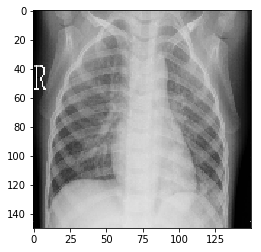

In [219]:
plt.imshow(X_val[0])

In [220]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_val=X_val.astype(np.float32)

# add a channels dimension:
# X_train = X_train[..., None]
# X_test = X_test[..., None]
# X_val=X_val[...,None]



In [221]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [222]:
X_train_or_test = tf.placeholder(tf.float32, [None, 150, 150,1], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = batch_size

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [214]:
net = X_batch

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
# net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
# net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
# net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=64, activation=tf.nn.relu)
net = tf.layers.dropout(net,rate=0.5)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=1)

logits = net

loss=tf.losses.sigmoid_cross_entropy(y_batch,logits)
# loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=1), logits=logits)

ValueError: Shapes (?, 1) and (?,) are incompatible

In [209]:
train_op = tf.train.RMSPropOptimizer(learning_rate=.001).minimize(loss)

In [210]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [211]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
for i in range(300):
    _, loss_i = sess.run([train_op, loss])
    if i%100 == 0:
        print(loss_i)

0.0
0.0
0.0


In [212]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
correct = 0
total = 0
for i in range(10):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print(acc)

0.0


In [201]:
prediction

array([[  8.890652 ,  -9.464996 ],
       [  8.5232935,  -9.082049 ],
       [  7.7752695,  -8.244809 ],
       [  8.972745 ,  -9.547291 ],
       [  9.17795  ,  -9.777026 ],
       [  8.711329 ,  -9.288294 ],
       [  7.4576774,  -7.9220576],
       [  9.448149 , -10.046732 ],
       [  9.345196 ,  -9.93643  ],
       [  8.000479 ,  -8.510602 ],
       [  9.161207 ,  -9.771768 ],
       [  8.930732 ,  -9.53352  ],
       [  8.968417 ,  -9.571404 ],
       [  8.120799 ,  -8.665486 ],
       [  8.118938 ,  -8.650258 ],
       [  7.571579 ,  -8.06044  ]], dtype=float32)

In [192]:
truth

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [197]:
total

160